In [7]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
# Importar datos de la base de datos
import pymysql
# Análisis Exploratorio
from pandas_profiling import ProfileReport
# Outliers
import seaborn as sns
import datetime

# Extracción de MySQL

In [2]:
# Conexion a la base de datos y extracción de datos
#miConexion = pymysql.connect(
#    host = "*****************", 
#    port = ***************** , 
#    user = "*****************", 
#    passwd = "*****************", 
#    db = "*****************")

In [3]:
# Extracción de datos
#datosBrutos = pd.read_sql(con=miConexion, sql="SELECT * FROM Datos", index_col="Date", parse_dates = "Date")
#datos.head()

In [4]:
# Cierre de la conexion
#miConexion.close()

## Filtro de datos

In [5]:
# Modificación Cam no disponible y Fondo no disponible
## -1 Cam no disponible
## -2 Fondo no disponible
datosBrutos.loc[datosBrutos['Ocupacion'] == "Cam NO Disponible", 'Ocupacion'] = '-1'
datosBrutos.loc[datosBrutos['Ocupacion'] == "Fondo NO Disponible", 'Ocupacion'] = '-2'

# Este solo es para el dataset extraido de Matlab
datosBrutos.loc[datosBrutos['Ocupacion'] == "NO DISPONIBLE", 'Ocupacion'] = '-3'

datosBrutos["Ocupacion"] = datosBrutos["Ocupacion"].astype(float)

In [6]:
datosNoDisponibles = datosBrutos[datosBrutos["Ocupacion"] < 0].copy()
datos = datosBrutos[datosBrutos["Ocupacion"] >= 0].copy()

In [7]:
# Creamos un diccionario siendo la clave la camaras disponibles y no disponibles
df = {}
for cam in datos["Camara"].unique():
    df[cam] = datos[datos["Camara"] == cam]

dfNo = {}
for cam in datosNoDisponibles["Camara"].unique():
    dfNo[cam] = datosNoDisponibles[datosNoDisponibles["Camara"] == cam]

In [ ]:
# Normalizo los datos con el bigote superior para no eliminar los outliers, de manera que mi maximo es el bigote superior
for clave in df.keys():
    aux = df[clave]
    
    Q1 = aux["Ocupacion"].quantile(0.25)
    Q3 = aux["Ocupacion"].quantile(0.75)
    IQR = Q3 - Q1
    
    BS_Calculado = (Q3 + 1.5 * IQR)
    
    ## Normalización
    minimo = aux["Ocupacion"].min()
    maximo = BS_Calculado
    aux["Ocupacion"]=(aux["Ocupacion"]-minimo)/(maximo-minimo)
    
    df[clave] = aux

## Modifico la tabla de datos

In [9]:
# Creamos ls dataFrames vacíos
dfDisponible = pd.DataFrame()
dfNoDisponible = pd.DataFrame()

In [10]:
# Cam disponibles
for clave in df.keys():
    aux = df[clave].copy()
    aux["Ocupa_" + clave] = aux["Ocupacion"]
    del(aux["Camara"])
    del(aux["Ocupacion"])
    aux = aux.loc[~aux.index.duplicated(keep='first')]
    dfDisponible = pd.concat([dfDisponible, aux], axis = 1)

# Cam no disponibles
for clave in dfNo.keys():
    aux = dfNo[clave].copy()
    aux["Ocupa_" + clave] = aux["Ocupacion"]
    del(aux["Camara"])
    del(aux["Ocupacion"])
    aux = aux.loc[~aux.index.duplicated(keep='first')]
    dfNoDisponible = pd.concat([dfNoDisponible, aux], axis = 1)

## Añado comportamiento medio de la ciudad

In [11]:
dfDisponible["Ocupa_Ciudad"] = dfDisponible[list(dfDisponible)].sum(axis=1) / len(list(dfDisponible))

## Añado dia de la semana 

In [12]:
dfDisponible = dfDisponible.reset_index()
dfDisponible["Day"] = dfDisponible["Date"].dt.dayofweek
dfDisponible = dfDisponible.set_index("Date")

## Analisis Exploratorio

In [ ]:
profile = ProfileReport(dfDisponible, minimal = True)
profile.to_file(output_file="Analisis_Exploratorio.html")

profile2 = ProfileReport(dfNoDisponible, minimal = True)
profile2.to_file(output_file="Analisis_Exploratorio2.html")

## Guardo valores Anómalos y dataFrame modificado y normalizado

In [14]:
dfDisponible.to_csv("./DatosNormalizados.csv")
dfNoDisponible.to_csv("./DatosAnomalos.csv")

# Leo datos de .csv

In [8]:
dataFrame = pd.read_csv("DatosNormalizados.csv", dtype=float, index_col = 0, parse_dates = True)
datosAnomalos = pd.read_csv("DatosAnomalos.csv", dtype=float, index_col = 0, parse_dates = True)

# Analizo Datos

## Ocupación por horas

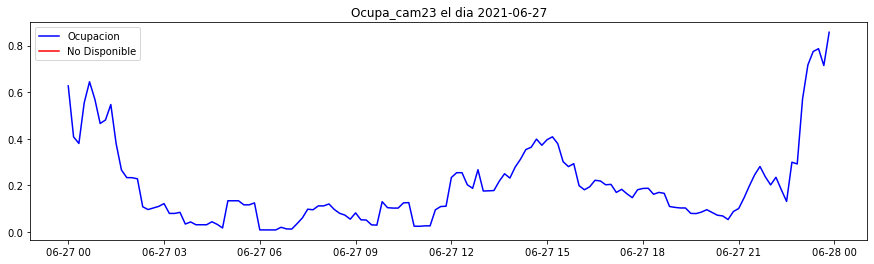

In [9]:
cam = "Ocupa_cam23"
dia = "2021-06-27" # Sabado

fix, ax = plt.subplots(figsize = (15,4))
#plt.plot(dataFrame.loc[dia][[cam]].resample("30T").mean(), label = "Ocupacion", color = "blue")
plt.plot(dataFrame.loc[dia][[cam]].rolling("1H").mean(), label = "Ocupacion", color = "blue")
plt.plot(datosAnomalos.loc[dia][[cam]], label = "No Disponible", color = "red")
plt.title(cam + " el dia " + dia)
plt.legend()
plt.show()

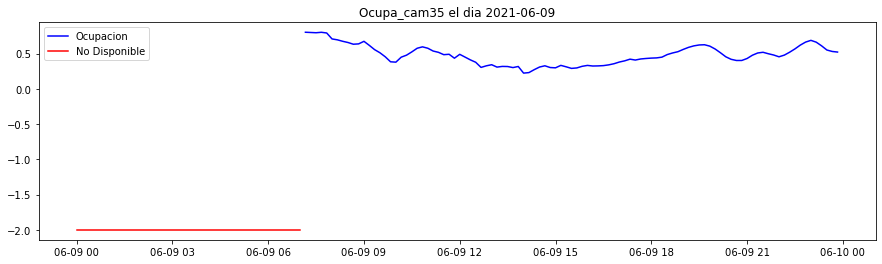

In [10]:
cam = "Ocupa_cam35"
dia = "2021-06-09"

fix, ax = plt.subplots(figsize = (15,4))
#plt.plot(dataFrame.loc[dia][[cam]].resample("30T").mean(), label = "Ocupacion", color = "blue")
plt.plot(dataFrame.loc[dia][[cam]].rolling("1H").mean(), label = "Ocupacion", color = "blue")
plt.plot(datosAnomalos.loc[dia][[cam]], label = "No Disponible", color = "red")
plt.title(cam + " el dia " + dia)
plt.legend()
plt.show()

## Actividad diaria por camara

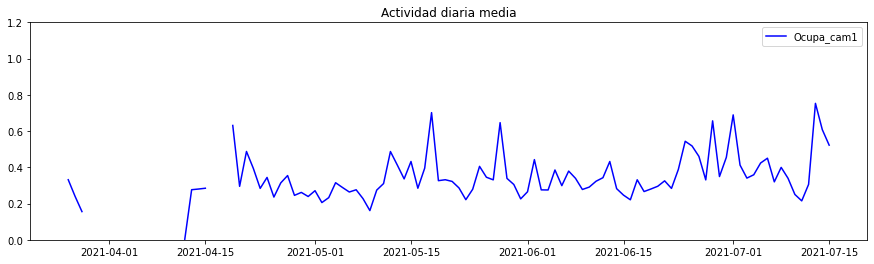

In [11]:
cam = "Ocupa_cam1"
fix, ax = plt.subplots(figsize = (15,4))
plt.plot(dataFrame[cam].resample("d").mean(), label = cam, color = "blue")
plt.title("Actividad diaria media")
plt.ylim(0,1.2)
plt.legend()
plt.show()

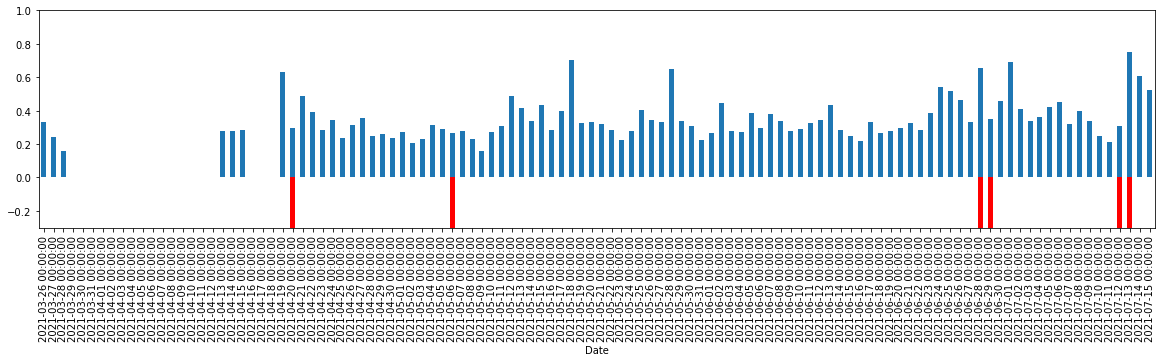

In [12]:
fix, ax = plt.subplots(figsize = (20,4))
dispo = dataFrame[cam].resample("d").mean()
ax1 = dispo.plot(kind='bar')
noDispo = datosAnomalos[cam].resample("d").mean()
ax2 = noDispo.plot(kind='bar', color = "red")
ax1.set_ylim(-0.3,1)
plt.show()

## Actividad actual ciudad

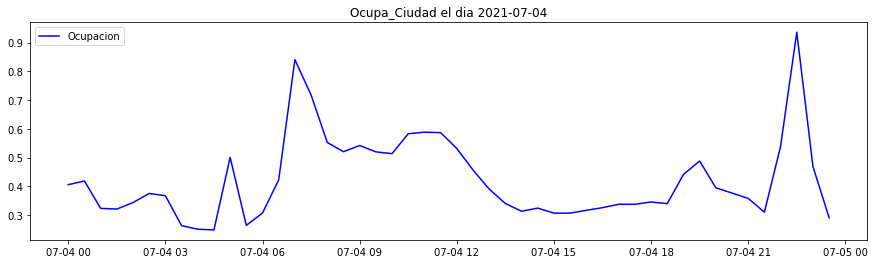

In [13]:
cam = "Ocupa_Ciudad"
dia = "2021-07-04" # Lunes

fix, ax = plt.subplots(figsize = (15,4))
plt.plot(dataFrame.loc[dia][[cam]].resample("30T").mean(), label = "Ocupacion", color = "blue")
plt.title(cam + " el dia " + dia)
plt.legend()
plt.show()

## Comportamiento días

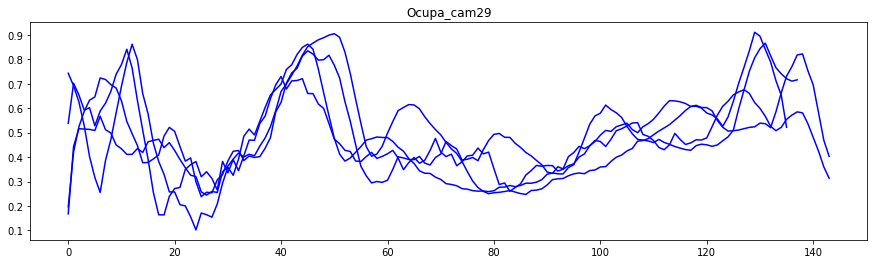

In [20]:
fix, ax = plt.subplots(figsize = (15,4))
for j in ["2021-06-29","2021-06-22","2021-06-15","2021-06-08"]:
    for i in range(29,30):
        cam = "Ocupa_cam" + str(i)
        dia = j # "2021-06-29" # Sabado

        #plt.plot(dataFrame.loc[dia][[cam]].resample("30T").mean(), label = "Ocupacion", color = "blue")
        plt.plot(range(len(dataFrame.loc[dia][[cam]].rolling("1H").mean())),dataFrame.loc[dia][[cam]].rolling("1H").mean(), label = "Ocupacion", color = "blue")
        #plt.plot(datosAnomalos.loc[dia][[cam]], label = "No Disponible", color = "red")
        plt.title(cam)# + " el dia " + dia)
        #plt.legend()
plt.show()

In [301]:
#Filtro sólo horas de sol ( 8am y 21 pm)
df = pd.DataFrame(columns = dataFrame.columns)

for index, row in dataFrame.iterrows():
    if (index.hour > 8) and (index.hour < 21):
        df = df.append(dataFrame.loc[index])

In [354]:
cam = "Ocupa_cam23"
prueba = df[[cam, "Day"]].resample("d").mean()

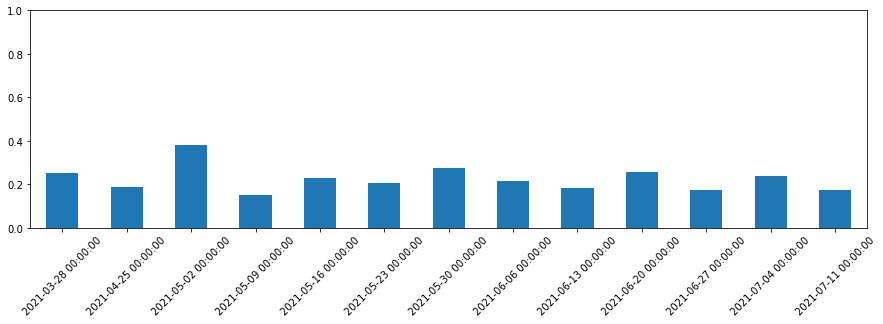

In [357]:
# Domingo
dia = 6
fix, ax = plt.subplots(figsize = (15,4))
todosDias = prueba[prueba["Day"] == dia]
ax = todosDias[cam].plot(kind = "bar")
ax.set_ylim(0,1)
plt.xticks(rotation=45)
plt.show()

## Estudio de los días de una semana

In [37]:
mediaDia = df.groupby(["Day"]).mean()

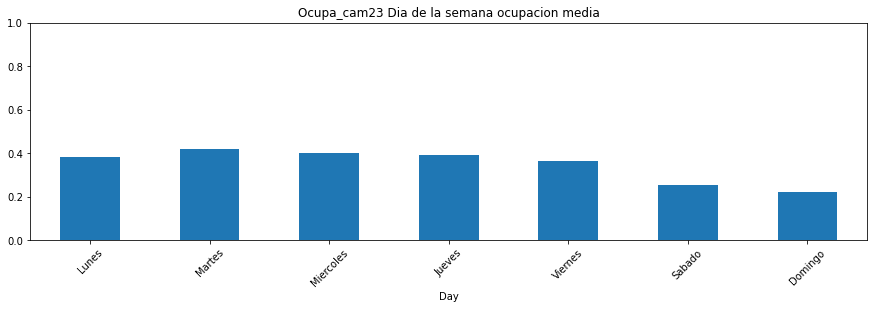

In [363]:
cam = "Ocupa_cam23"
fix, ax = plt.subplots(figsize = (15,4))
ax = mediaDia[cam].plot(kind = "bar")
ax.set_ylim(0,1)
plt.title(cam + " Dia de la semana ocupacion media")
new_xticks=["Lunes", "Martes", "Miercoles", "Jueves", "Viernes", "Sabado", "Domingo"]
plt.xticks( [0,1,2,3,4,5,6], new_xticks)
plt.xticks(rotation=45)
plt.show()

## Datos Anómalos

In [425]:
dat = datosAnomalos
d = dat.describe()

In [427]:
a = d[d.index == "count"]
a2 = a.values.tolist()
b = a2[0].copy()
b.sort()
peores = (b[-15:])

In [458]:
nombres = []
cantidad = []
for num in peores:
    pos = np.where(np.asarray(a2[0]) == num)[0][0]
    nombres.append(a.iloc[:,pos].name)
    cantidad.append(num)

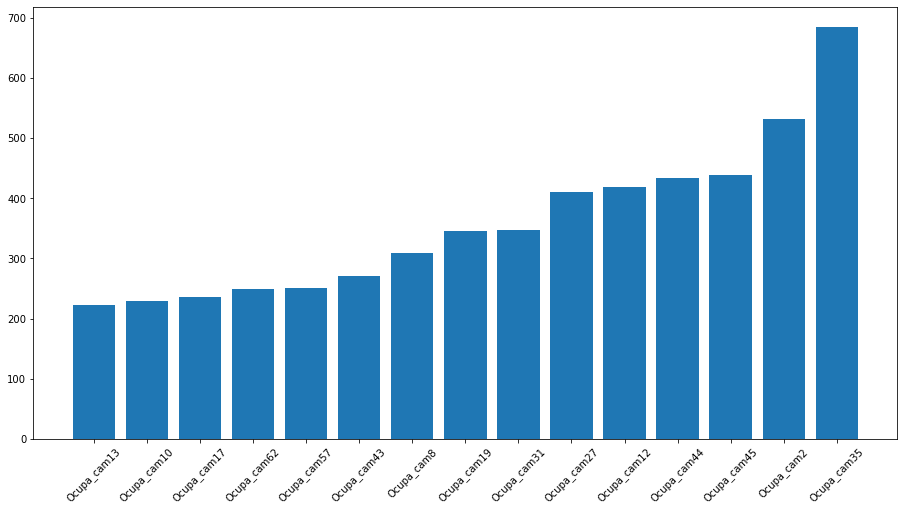

In [470]:
fig = plt.figure(figsize = (12,6))
ax = fig.add_axes([0,0,1,1])
langs = ['C', 'C++', 'Java', 'Python', 'PHP']
students = [23,17,35,29,12]
ax.bar(nombres,cantidad)
plt.xticks(rotation=45)
plt.show()

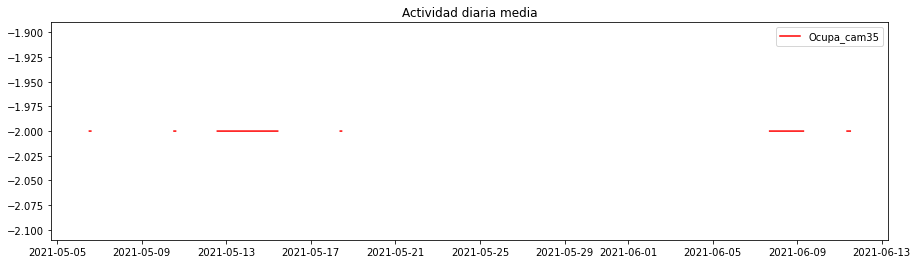

In [366]:
cam = "Ocupa_cam35"
fix, ax = plt.subplots(figsize = (15,4))
plt.plot(dat[cam], label = cam, color = "red")
plt.title("Actividad diaria media")
plt.legend()
plt.show()

## Correlación de Pearson

In [44]:
dfPearson = dataFrame.resample("h").mean()

In [45]:
#dfFinesSemana = dfPearson[(dfPearson["Day"] == 5) | (dfPearson["Day"] == 6)]
dfEntrSemana  = dfPearson[(dfPearson["Day"] != 5) & (dfPearson["Day"] != 6)]

In [46]:
#pearson = dfFinesSemana.corr(method = "pearson")
pearson = dfEntrSemana.corr(method = "pearson")

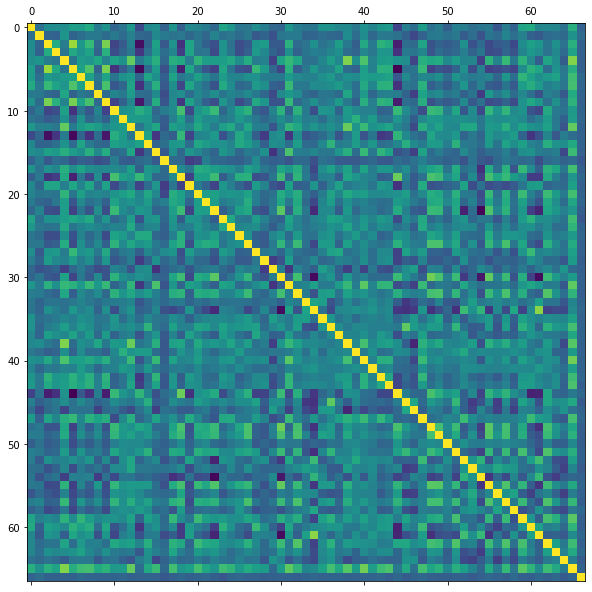

In [47]:
plt.figure(figsize=(10, 10))
plt.matshow(pearson, fignum = 1)

In [48]:
# Para una visualización bonita de las tablas
from IPython.display import display

valorCorrelacion = 0.68
for cam in pearson.columns:
    pearsonFil = pearson.loc[:,[cam]]
    pearsonFilCam = pearsonFil[pearsonFil[cam] > valorCorrelacion]
    if pearsonFilCam.shape[0] > 1:
        display(pearsonFilCam)

,Ocupa_cam3
Ocupa_cam3,1.000000
Ocupa_cam6,0.781159
Ocupa_cam11,0.700473


,Ocupa_cam5
Ocupa_cam5,1.000000
Ocupa_cam44,0.722003
Ocupa_Ciudad,0.724414


,Ocupa_cam6
Ocupa_cam3,0.781159
Ocupa_cam6,1.000000
Ocupa_cam11,0.705416


,Ocupa_cam11
Ocupa_cam3,0.700473
Ocupa_cam6,0.705416
Ocupa_cam11,1.000000


,Ocupa_cam33
Ocupa_cam33,1.000000
Ocupa_cam55,0.687885


,Ocupa_cam38
Ocupa_cam38,1.000000
Ocupa_cam37,0.746193


,Ocupa_cam44
Ocupa_cam5,0.722003
Ocupa_cam44,1.000000


,Ocupa_cam46
Ocupa_cam46,1.000000
Ocupa_Ciudad,0.686431


,Ocupa_cam55
Ocupa_cam33,0.687885
Ocupa_cam55,1.000000


,Ocupa_cam37
Ocupa_cam38,0.746193
Ocupa_cam37,1.000000


,Ocupa_Ciudad
Ocupa_cam5,0.724414
Ocupa_cam46,0.686431
Ocupa_Ciudad,1.000000


## K-means

In [51]:
from sklearn.cluster import KMeans

In [206]:
outNa = dataFrame.resample("d").mean().dropna().drop(columns='Day').T

C:\Users\Ricar\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:881: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


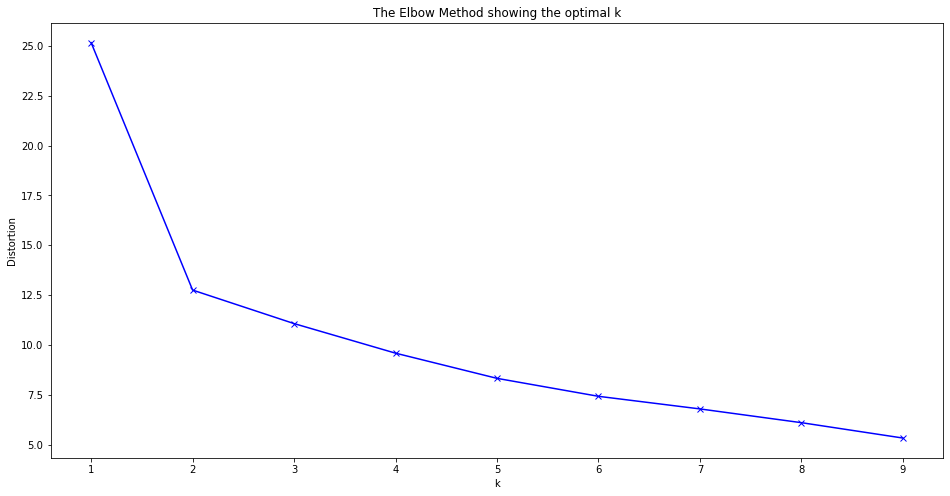

In [208]:
# Estudio num clusters ELBOW ( Varianza intra clusters )
    #https://www.cienciadedatos.net/documentos/py20-clustering-con-python.html
distortions = []
K = range(1,10)
for k in K:
    kmeans = kmeanModel = KMeans(n_clusters=k).fit(outNa)
    distortions.append(kmeans.inertia_)

plt.figure(figsize=(16,8))
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()

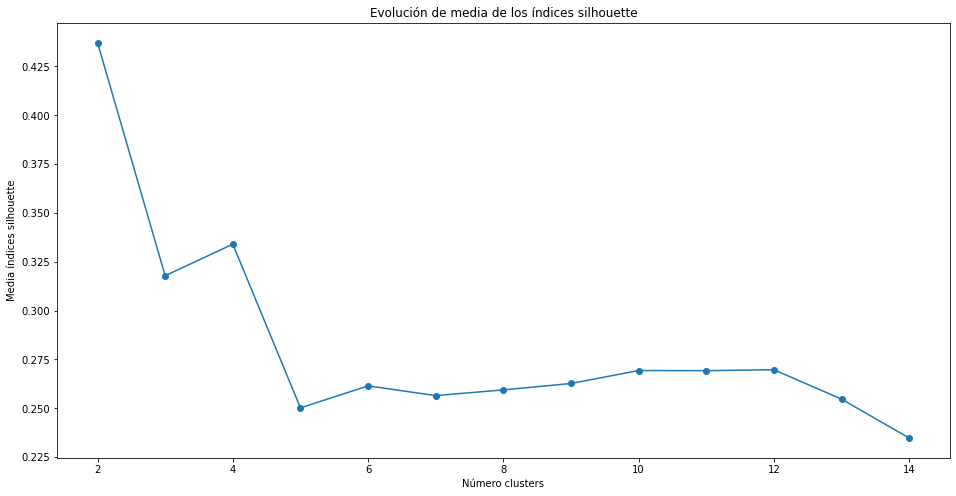

In [209]:
# Estudio num clusters Método average silhouette
    #https://www.cienciadedatos.net/documentos/py20-clustering-con-python.html
    
from sklearn.metrics import silhouette_score

range_n_clusters = range(2, 15)
valores_medios_silhouette = []

for n_clusters in range_n_clusters:
    modelo_kmeans = KMeans(n_clusters = n_clusters)
    cluster_labels = modelo_kmeans.fit_predict(outNa)
    silhouette_avg = silhouette_score(outNa, cluster_labels)
    valores_medios_silhouette.append(silhouette_avg)
    
fig, ax = plt.subplots(1, 1, figsize=(16,8))
ax.plot(range_n_clusters, valores_medios_silhouette, marker='o')
ax.set_title("Evolución de media de los índices silhouette")
ax.set_xlabel('Número clusters')
ax.set_ylabel('Media índices silhouette');

In [218]:
# Como se entrena un kmeans
kmeans = KMeans(n_clusters=2).fit(outNa)  # random state es como inicializar la semilla para obtener los mismos parametros
                                                          # fit es para que cree el modelo 
centroids = kmeans.cluster_centers_

In [219]:
#print(kmeans.labels_)
#print(centroids)

## Representación en un Mapa

In [479]:
import folium

In [480]:
# Leemos datos, asignamos nombres a las columnas, asignamos que el índice es la fecha y parse_dates para decir que son fechas.
pos = pd.read_csv("Posiciones.csv", names=["lat","lon"], dtype=float, index_col = 0)
#pos.head()

In [481]:
marcadores = []
for i in range(0,len(pos)):
    marcadores.append([pos.iloc[i,0], pos.iloc[i,1]])

In [482]:
mapa = folium.Map(location=[37.3826, -5.99629], tiles='Stamen Toner', zoom_start = 12.5)
mapa2 = folium.Map(location=[37.3826, -5.99629], tiles='Stamen Toner', zoom_start = 12.5)
mapa3 = folium.Map(location=[37.3826, -5.99629], tiles='Stamen Toner', zoom_start = 12.5)

In [490]:
# Representa Cámaras no disponibles
a = 0
for k in range(0, len(outNa.index)):
    if outNa.index[k] in nombres:
        col = "red"
        marc = marcadores[int(outNa.index[k].split("cam")[1]) - 1]
        folium.Marker(marc,icon=folium.Icon(color=col, icon="info-sign")).add_to(mapa3)
    a = a+1

mapa3

In [484]:
# Representación kmeans
a = 0
for k in range(0, len(outNa.index)):
    if outNa.index[k] != "Ocupa_Ciudad" and outNa.index[k] != "Ocupa_cam66":
        valor = kmeans.labels_[k]
        if valor == 0:
            col = "blue"
        elif valor == 1:
             col = "purple"
        marc = marcadores[int(outNa.index[a].split("cam")[1]) - 1]
        folium.Marker(marc,icon=folium.Icon(color=col, icon="info-sign")).add_to(mapa2)
    a = a+1

mapa2

In [486]:
# Representa Ocupación 
tupla = len(dataFrame) - 1

i = 0
for marc in marcadores: 
        aux = dataFrame["Ocupa_cam" + str(int(pos.index[i]))]
        i += 1
        valor = aux.iloc[tupla]
        
        if (pd.isnull(aux.iloc[tupla])):
            col = "black"
        else:
            if valor < 0.3:
                col = "green"
            elif valor < 0.6:
                col = "orange"
            else:
                col = "red"
        folium.Marker(marc,icon=folium.Icon(color=col, icon="info-sign")).add_to(mapa)

print(dataFrame.iloc[tupla,:].name)
print(dataFrame["Ocupa_Ciudad"][-1])

2021-07-12 21:30:00
0.2831356920869114


In [487]:
mapa 

## Diagrama de Voronoi

In [228]:
from scipy.spatial import Voronoi, voronoi_plot_2d

In [229]:
for i in range(0,len(marcadores)):
    marcadores[i][0], marcadores[i][1] = marcadores[i][1], marcadores[i][0]

#Use scipy to make the voronoi diagram:
vor = Voronoi(marcadores, qhull_options='Qbb Qc Qx')

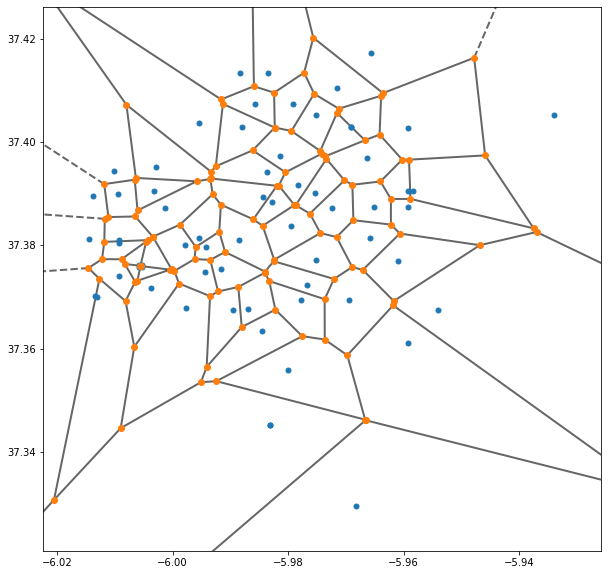

In [230]:
fig = plt.figure(figsize=(10, 10))
voronoi_plot_2d(vor, ax=fig.gca(), line_width=2, line_alpha=0.6, point_size=10)
plt.show()

In [231]:
import smopy #pip install git+https://github.com/rossant/smopy.git
import matplotlib as mpl 
import smopy 
#%matplotlib inline

In [232]:
# Crea un dataframe con los marcadores
df = pd.DataFrame(marcadores)

In [233]:
# Asignamos longitud, latitud y numeros de camaras
lon = df[0]
lat = df[1]
numCams = len(lon)

In [234]:
# Asignamos la region para que la libreria smopy recorte el mapa
box = (lat.min(), lon.min(),
       lat.max(), lon.max())
m = smopy.Map(box, z=12)

In [235]:
# Creamos el diagrama de Voronoi, pero esta vez le pasamos un numpy array concatenando posiciones 
vor = Voronoi(np.c_[lat, lon])

In [236]:
# Creamos las regiones a partir de la figura de voronoi
def voronoi_finite_polygons_2d(vor, radius=None):
    """Reconstruct infinite Voronoi regions in a
    2D diagram to finite regions.
    Source:
    [https://stackoverflow.com/a/20678647/1595060](https://stackoverflow.com/a/20678647/1595060)
    """
    if vor.points.shape[1] != 2:
        raise ValueError("Requires 2D input")
    new_regions = []
    new_vertices = vor.vertices.tolist()
    center = vor.points.mean(axis=0)
    if radius is None:
        radius = vor.points.ptp().max()
    # Construct a map containing all ridges for a
    # given point
    all_ridges = {}
    for (p1, p2), (v1, v2) in zip(vor.ridge_points,
                                  vor.ridge_vertices):
        all_ridges.setdefault(
            p1, []).append((p2, v1, v2))
        all_ridges.setdefault(
            p2, []).append((p1, v1, v2))
    # Reconstruct infinite regions
    for p1, region in enumerate(vor.point_region):
        vertices = vor.regions[region]
        if all(v >= 0 for v in vertices):
            # finite region
            new_regions.append(vertices)
            continue
        # reconstruct a non-finite region
        ridges = all_ridges[p1]
        new_region = [v for v in vertices if v >= 0]
        for p2, v1, v2 in ridges:
            if v2 < 0:
                v1, v2 = v2, v1
            if v1 >= 0:
                # finite ridge: already in the region
                continue
            # Compute the missing endpoint of an
            # infinite ridge
            t = vor.points[p2] - \
                vor.points[p1]  # tangent
            t /= np.linalg.norm(t)
            n = np.array([-t[1], t[0]])  # normal
            midpoint = vor.points[[p1, p2]]. \
                mean(axis=0)
            direction = np.sign(
                np.dot(midpoint - center, n)) * n
            far_point = vor.vertices[v2] + \
                direction * radius
            new_region.append(len(new_vertices))
            new_vertices.append(far_point.tolist())
        # Sort region counterclockwise.
        vs = np.asarray([new_vertices[v]
                         for v in new_region])
        c = vs.mean(axis=0)
        angles = np.arctan2(
            vs[:, 1] - c[1], vs[:, 0] - c[0])
        new_region = np.array(new_region)[
            np.argsort(angles)]
        new_regions.append(new_region.tolist())
    return new_regions, np.asarray(new_vertices)

In [237]:
# Una vez calculado las regiones y los vertices, insertamos en el recorte los datos extraidos de la forma que lo quiere la libreria
regions, vertices = voronoi_finite_polygons_2d(vor)
cells = [m.to_pixels(vertices[region])
         for region in regions]

In [247]:
cmap = plt.cm.Set3
# Generamos los colores para cada camara
colors_districts = cmap(np.linspace(0.,0., numCams))[:, :3]

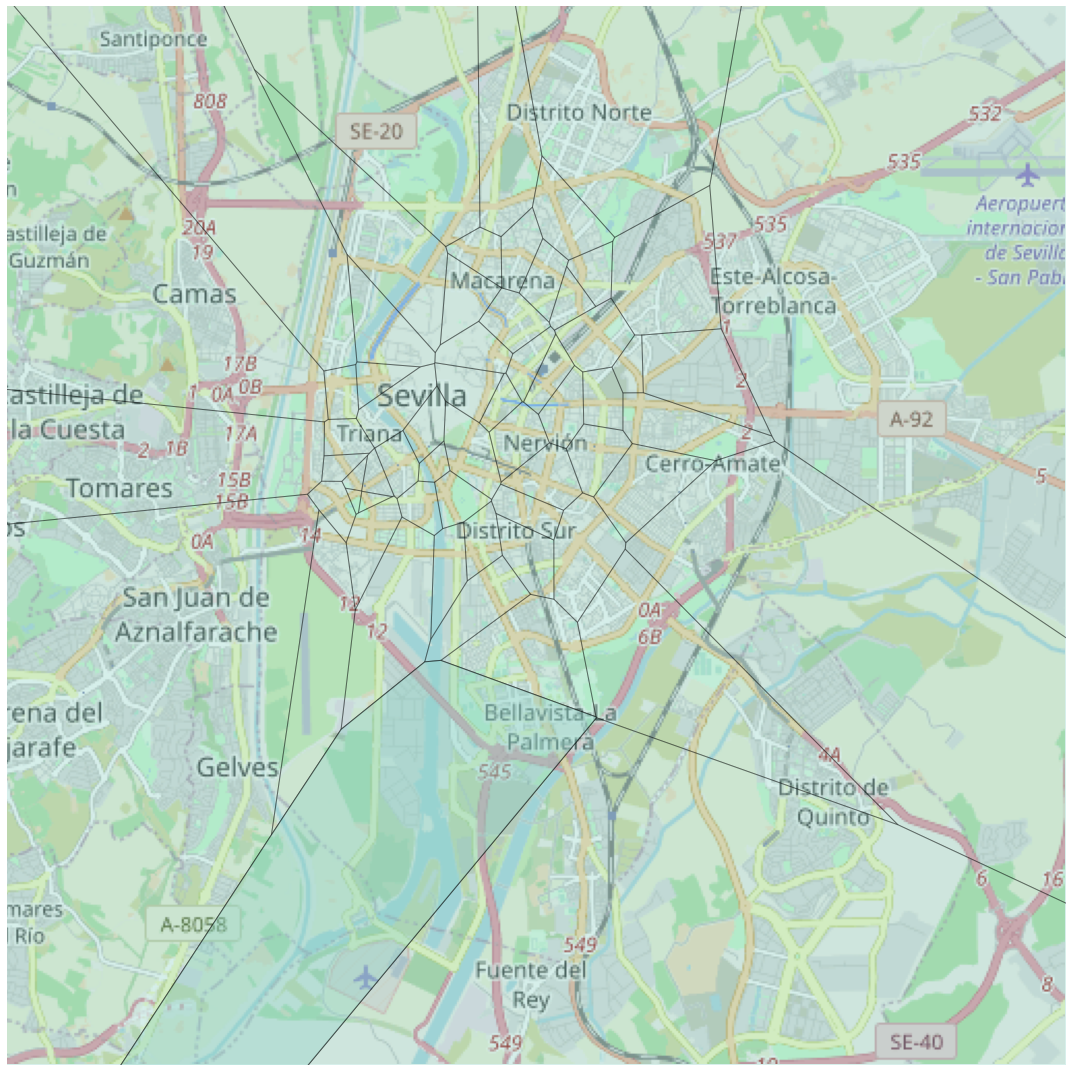

In [250]:
ax = m.show_mpl(figsize=(15, 15))
ax.add_collection(
    mpl.collections.PolyCollection(
        cells, facecolors=colors_districts,
        edgecolors='k', alpha=.35))
plt.show()